In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import glob
import pickle

from moviepy.editor import VideoFileClip

from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore')

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')
print(len(images))

20


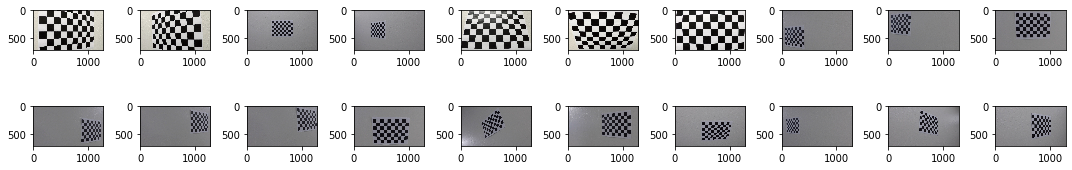

In [3]:
fig, ax = plt.subplots(2, 10, figsize=(15, 3))
ii = 0
for i in range(2):
    for j in range(10):
        img = mpimage.imread(images[ii])
        ax[i, j].imshow(img)
        ii += 1 
        ax[i, j].set_aspect('equal')
plt.tight_layout();

## Object Points and Image Points

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9, 3), np.float32)
print(objp.shape)

mat = np.mgrid[0:9, 0:6]
print(mat.shape)

mat = mat.T
print(mat.shape)

mat = mat.reshape(-1, 2)
print(mat.shape)
print(mat[:2])

objp[:, :2] = mat 

print(objp[:10])

(54, 3)
(2, 9, 6)
(6, 9, 2)
(54, 2)
[[0 0]
 [1 0]]
[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]]


In [5]:
# Arrays to store object points and image points from all the images.

objpoints = [] # 3D
imgpoints = [] # 2D

nx = 9 # Inside corners in x
ny = 6 # Inside corners in y

display(Markdown(f'**We will find {nx} object points on x-axis and {ny} object points on y-axis**'))

**We will find 9 object points on x-axis and 6 object points on y-axis**

In [6]:
import time

for idx, fname in enumerate(images):
    image = mpimage.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find Chess Corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #image = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        #cv2.imshow('image', image)      
        #cv2.waitKey(500)
        
#cv2.destroyAllWindows()

In [7]:
print(np.array(imgpoints).shape)
print(np.array(objpoints).shape)

print(objpoints[0][0])
print(imgpoints[0][0])

(17, 54, 1, 2)
(17, 54, 3)
[0. 0. 0.]
[[482.64066 241.92659]]


## Calibrate to calculate distortion coefficients, and test undistortion on an image!

(721, 1281, 3)


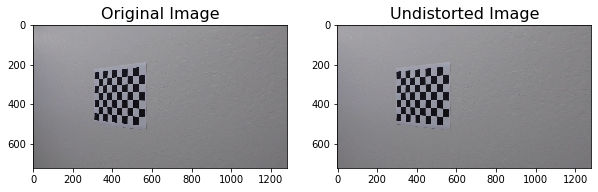

In [8]:
test_image = images[3]

image = mpimage.imread(test_image)
print(image.shape)

# Shape of the image, which is passed into the calibrateCamera function, is just the height and width of the image. 
image_size = image.shape[1::-1] # image.shape[1], image.shape[0]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

image_undist = cv2.undistort(image, mtx, dist, None, mtx)

f, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].imshow(image)
ax[1].imshow(image_undist)

ax[0].set_title('Original Image', fontsize=16)
ax[1].set_title('Undistorted Image', fontsize=16);

## Save Distortion Params

In [9]:
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist

dist_fname = './data/wide_dist_pickle.p'
pickle.dump(dist_pickle, open(dist_fname, 'wb'))

## Undistort Image using saved mtx and dist

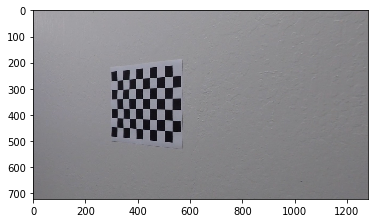

In [10]:
test_image = images[3]

dist_pickle = pickle.load(open(dist_fname, 'rb'))

mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

image = mpimage.imread(test_image)
image_size = image.shape[1::-1]

dst = cv2.undistort(image, mtx, dist, None, mtx)

plt.imshow(dst);

## Undistort and Transform Perspective

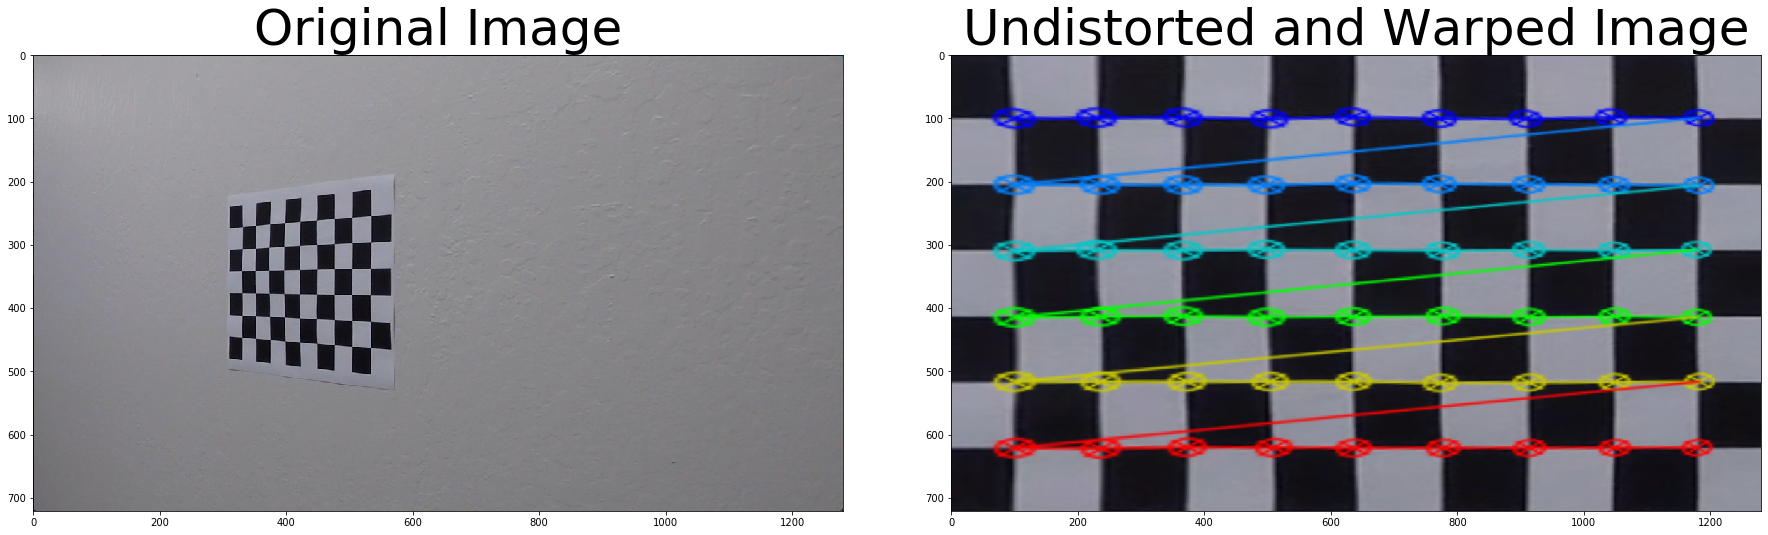

In [11]:
test_image = images[3]

dist_pickle = pickle.load(open(dist_fname, 'rb'))

mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

image = mpimage.imread(test_image)
image_size = image.shape[1::-1]

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(image, nx, ny, mtx, dist):
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret:
        dst = cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100
        image_size = image.shape[1::-1]
        
        # For source points I'm grabbing the outer four detected corners
        top_left, top_right = corners[0], corners[nx-1]
        bottom_right, bottom_left = corners[-1], corners[-nx]
        
        src = np.float32([top_left, top_right, bottom_right, bottom_left])
        
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        top_left, top_right = [offset, offset], [image_size[0] - offset, offset]
        bottom_right = [image_size[0] - offset, image_size[1] - offset]
        bottom_left = [offset, image_size[1] - offset]
        
        dst = np.float32([top_left, top_right, bottom_right, bottom_left])
        
        # Perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        warped = cv2.warpPerspective(undist, M, image_size)
        
    return warped, M

top_down, perspective_M = corners_unwarp(image, nx, ny, mtx, dist)

fig, ax = plt.subplots(1, 2, figsize=(24, 9))

ax[0].imshow(image)
ax[1].imshow(top_down)

ax[0].set_title('Original Image', fontsize=50)
ax[1].set_title('Undistorted and Warped Image', fontsize=50)

fig.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Apply a distortion correction to raw images.

In [12]:
def undistort(image):
    
    dist_pickle = pickle.load(open(dist_fname, 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    image_size = image.shape[1::-1]
    
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    return image

8


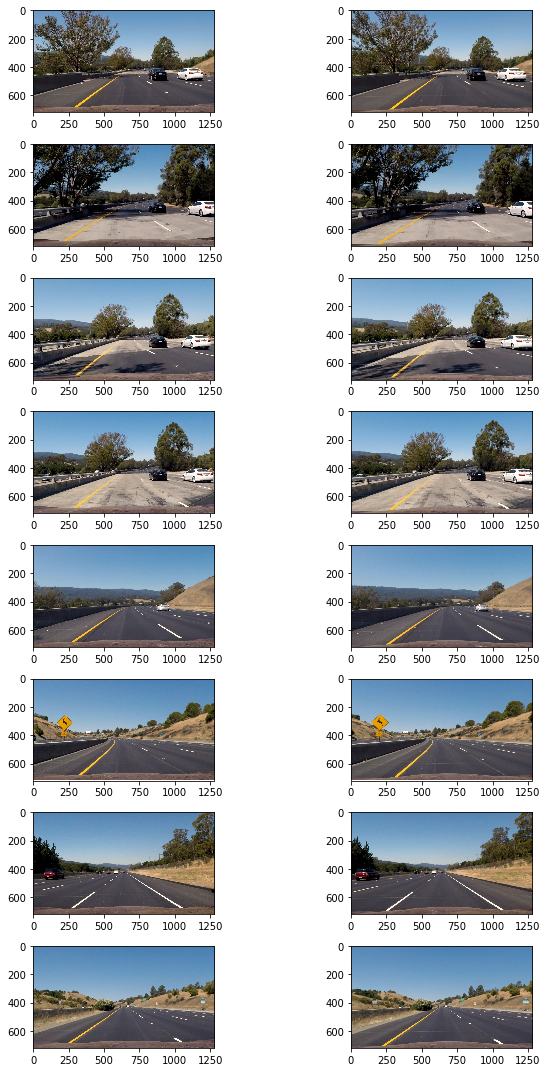

In [13]:
images = glob.glob('./test_images/*.jpg')
print(len(images))

fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    image = undistort(image)
    ax[i, 1].imshow(image, cmap='gray')

    #ax[0, i].set_aspect('equal')
    #ax[1, i].set_aspect('equal')
plt.tight_layout();

# Use color transforms, gradients, etc., to create a thresholded binary image.

In [14]:
def pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100), R_thresh = (200, 255)):
    
    image = undistort(image)
    
    image = np.copy(image)
    
    # R Channel
    R = image[:,:,0] 
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    sobelx_abs = np.absolute(sobelx)
    
    scale_factor = np.max(sobelx_abs) / 255
    scaled_sobel = np.uint8(sobelx_abs/scale_factor)
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1 
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold R color channel
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1
        
    # Activate binary image when two activated
    combined_binary = np.zeros_like(sx_binary)
    
    opt1 = (s_binary == 1) & (sx_binary == 1)
    opt2 = (sx_binary == 1) & (R_binary == 1)
    opt3 = (s_binary == 1) & (R_binary == 1)
    opt = opt1 | opt2 | opt3
    
    combined_binary[opt] = 1 

    return combined_binary 


8


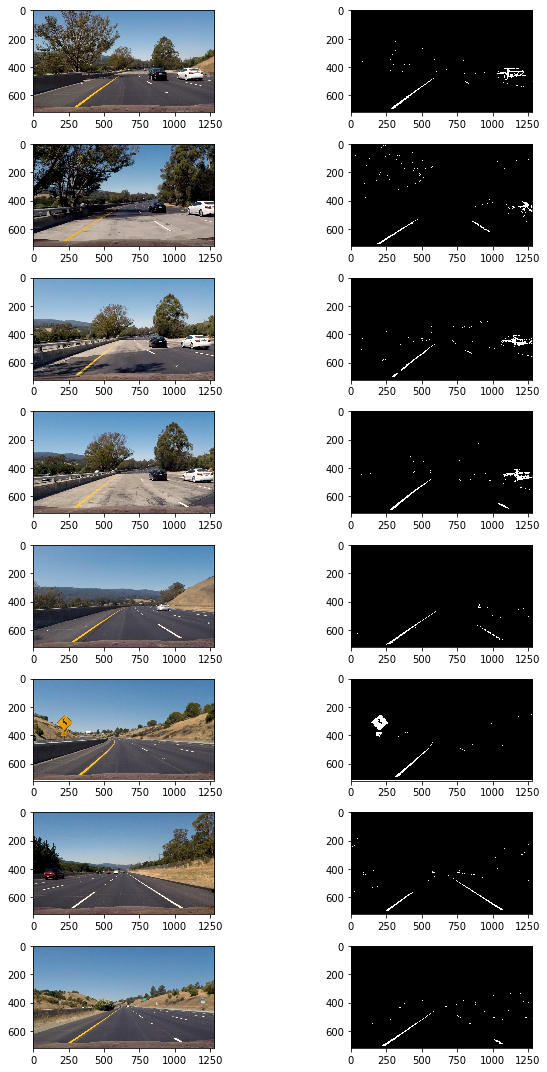

In [15]:
images = glob.glob('./test_images/*.jpg')
print(len(images))

fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    image = pipeline(image)
    ax[i, 1].imshow(image, cmap='gray')

plt.tight_layout();

# Apply a perspective transform to rectify binary image ("birds-eye view").

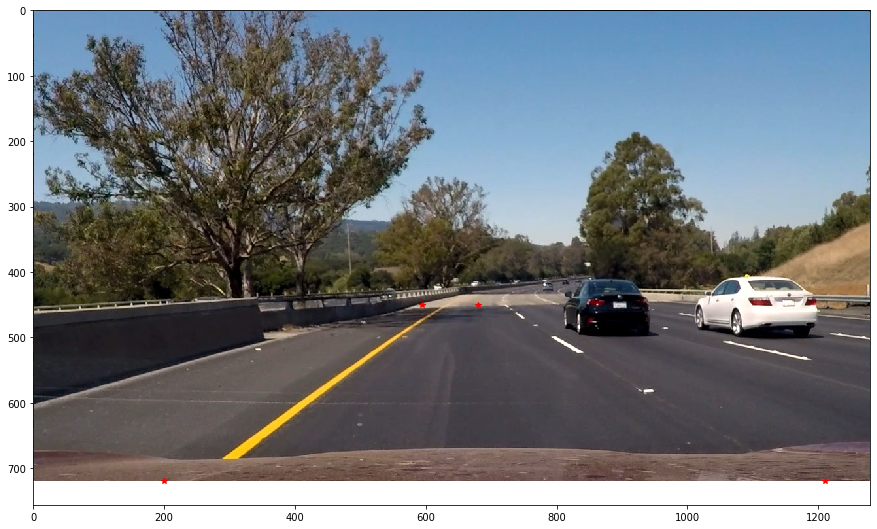

In [16]:
#%matplotlib qt 
plt.figure(figsize=(15, 15));

image = mpimage.imread(images[0])

plt.imshow(image);

w, h = image.shape[1], image.shape[0]

plt.plot(595, 450, '*', color='red')
plt.plot(680, 450, '*', color='red')
plt.plot(1210, h, '*', color='red')
plt.plot(200, h, '*', color='red');

In [17]:
def birds_eye(image):

    binary_img = pipeline(image)
    
    w, h = binary_img.shape[1], binary_img.shape[0]
    image_size = (w, h) #binary_img.shape[1::-1]
    
    # For source points - grabbing ROI
    top_left = [595, 450] 
    top_right = [685, 450]
    bottom_right = [1210, h]
    bottom_left = [200, h]
    
    src = np.float32([top_left, top_right, bottom_right, bottom_left])
    
    # Destination points
    offset = 300
    
    top_left = [offset, 0]
    top_right = [w - offset, 0]
    bottom_right = [w - offset, h]
    bottom_left = [offset, h]
    
    dst = np.float32([top_left, top_right, bottom_right, bottom_left])
    
    # Perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
        
    warped = cv2.warpPerspective(binary_img, M, image_size, flags=cv2.INTER_LINEAR)
        
    return warped, M

8


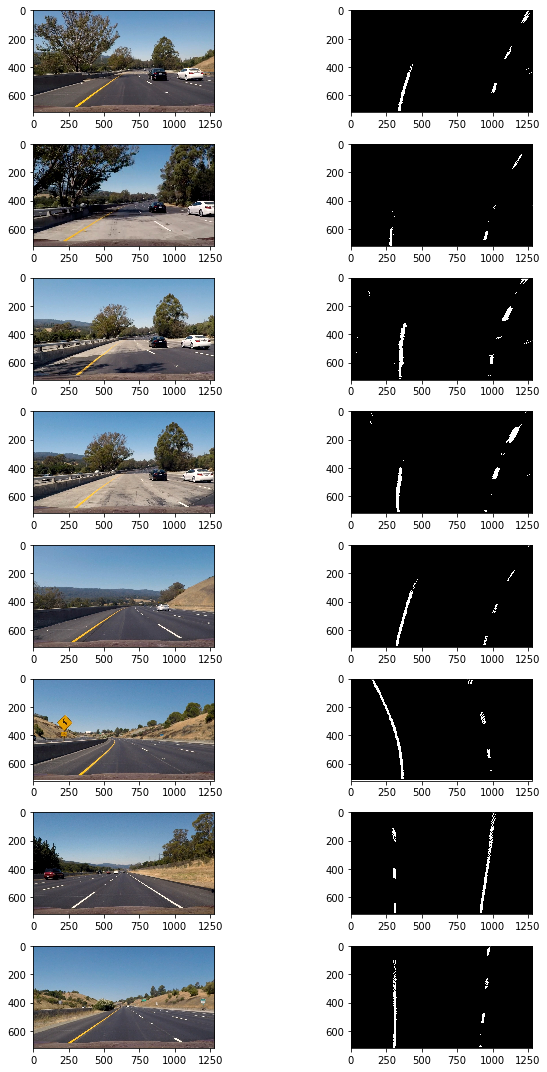

In [18]:
%matplotlib inline 
images = glob.glob('./test_images/*.jpg')
print(len(images))

fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    image, M = birds_eye(image)
    
    ax[i, 1].imshow(image, cmap='gray')

plt.tight_layout();

# Detect lane pixels and fit to find the lane boundary

## Sliding Window - Finding Lane

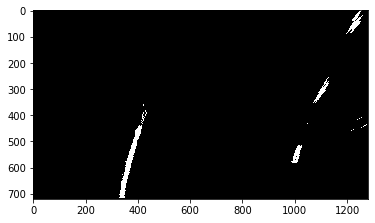

In [19]:
images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)

binary_warped, M = birds_eye(image)

def find_lane_pixels(binary_warped):
    
    # histogram
    h, w = binary_warped.shape[0], binary_warped.shape[1]
    
    half_image = binary_warped[h//2:, :]
    
    histogram = np.sum(half_image, axis=0)
    
    # out image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255 
    
    # histogram peaks and left/right lanes
    mid = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:mid])
    rightx_base = np.argmax(histogram[mid:]) + mid
        
    # Hyperparameters
    nwindows = 15  
    margin = 150   
    minpix = 50 
    window_height = h // nwindows
    
    # x and y positions of all nonzero pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    # Current Positions to be updated
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y
        
        win_y_high = h - window * window_height
        win_y_low = h - (window + 1) * window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
                
        
        # Draw the windows on the visualization image
        pt1 = (win_xleft_low, win_y_low)
        pt2 = (win_xleft_high, win_y_high)
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(out_img, pt1, pt2, color, thickness)
        
        pt1 = (win_xright_low, win_y_low)
        pt2 = (win_xright_high, win_y_high)
        cv2.rectangle(out_img, pt1, pt2, color, thickness)

        
        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                    (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high))
        good_left_inds = left_inds.nonzero()[0]

        right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                    (nonzerox >= win_xright_low) & (nonzerox < win_xright_high))
        good_right_inds = right_inds.nonzero()[0]
                
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            inds = nonzerox[good_left_inds]
            leftx_current = np.int(np.mean(inds))
            
        if len(good_right_inds) > minpix:
            inds = nonzerox[good_right_inds]
            rightx_current = np.int(np.mean(inds))
       
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
   
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
   
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img
    
plt.imshow(binary_warped, cmap='gray');

## Fit Polynomial

In [20]:
def fit_polynomial(binary_warped):
    
    h, w = binary_warped.shape[0], binary_warped.shape[1]
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    print(left_fit)
    print(right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, h-1, h)
    
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

[ 2.85842284e-04 -5.92619909e-01  6.14734010e+02]
[ 1.80581319e-04 -5.51462989e-01  1.25626613e+03]


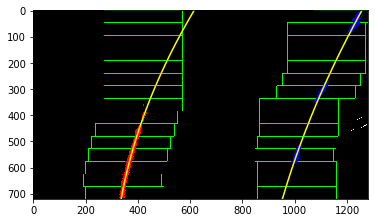

In [21]:
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img);

## Skip the sliding windows

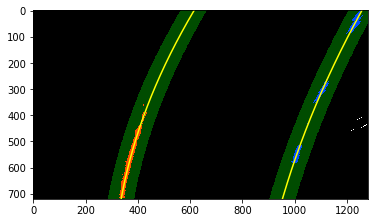

In [22]:
images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)

binary_warped, _ = birds_eye(image)

left_fit = np.array([2.85842284e-04, -5.92619909e-01, 6.14734010e+02])
right_fit = np.array([1.80581319e-04, -5.51462989e-01, 1.25626613e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    h, w = img_shape[0], img_shape[1]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, h-1, h)
    
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2] 
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, disp_fit=True):
    margin = 50
    
    # Grab Activate Pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    xvals = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    left_lane_inds = (nonzerox > xvals - margin) & (nonzerox < xvals + margin)

    xvals = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
    right_lane_inds = (nonzerox > xvals - margin) & (nonzerox < xvals + margin)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
                    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials # try
    if len(leftx) != 0 and len(rightx) != 0:
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    
    # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
        window_img = np.zeros_like(out_img)
    
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
        
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
        # Plot the polynomial lines onto the image
        if disp_fit and (len(leftx) != 0 and len(rightx) != 0):
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##

        return result, left_fitx, right_fitx, ploty
    else:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        left_fitx, right_fitx, ploty = [], [], []
        
        return result, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty = search_around_poly(binary_warped)

# View your output
plt.imshow(result);

## Lane Finding

8


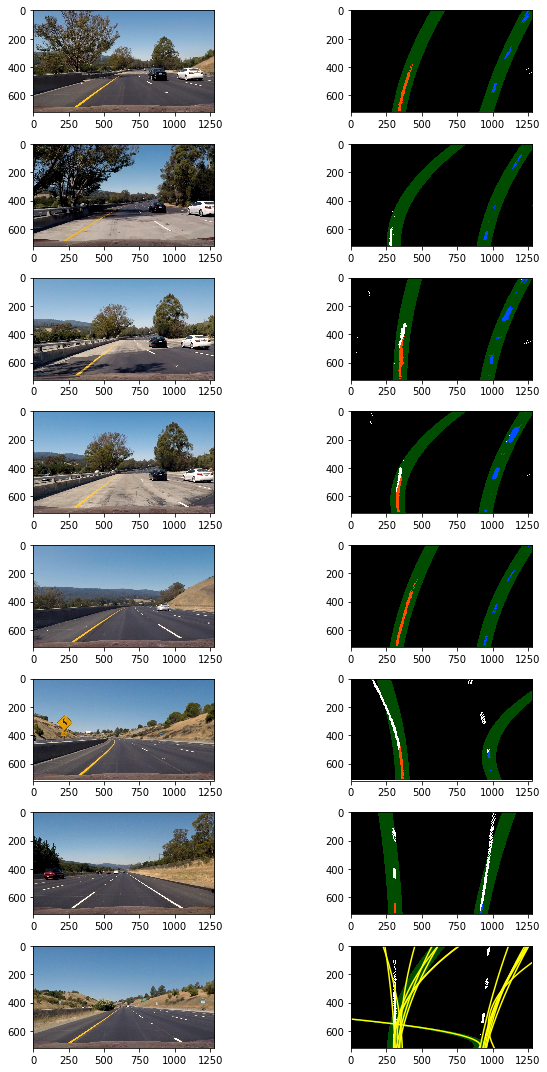

In [23]:
%matplotlib inline 
images = glob.glob('./test_images/*.jpg')
print(len(images))

fig, ax = plt.subplots(8, 2, figsize=(10, 15))

for i in range(8):
    image = mpimage.imread(images[i])
    ax[i, 0].imshow(image)
    
    binary_warped, _ = birds_eye(image)
    
    image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped)

    ax[i, 1].imshow(image)

plt.tight_layout();

# Measure Curvature

Left Curvature is 579 m and Right Curvature is 915 m
Centre is (647, 709)


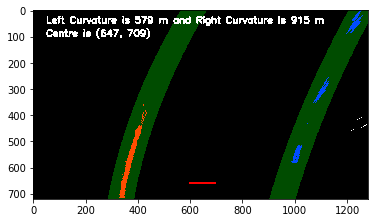

In [24]:
def measure_curvature_pixels(left_fitx, right_fitx, ploty):
    
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    
    y_eval = np.max(ploty)
        
    A, B, C = left_fit[0], left_fit[1], left_fit[2]
    
    left_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)

    A, B, C = right_fit[0], right_fit[1], right_fit[2]
    right_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)
        
    return left_curverad, right_curverad


def measure_curvature_real(left_fitx, right_fitx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = [lx * xm_per_pix for lx in left_fitx]
    right_fitx = [rx * xm_per_pix for rx in right_fitx]
    
    ploty = [py * ym_per_pix for py in ploty]
    
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)

    y_eval = np.max(ploty)
    
    
    A, B, C = left_fit[0], left_fit[1], left_fit[2]
    
    y_eval = y_eval * ym_per_pix 
    
    left_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)
    
    A, B, C = right_fit[0], right_fit[1], right_fit[2]
    
    right_curverad = (((1 + (2 * A * y_eval + B)**2))**1.5) / np.absolute(2*A)
        
    return left_curverad, right_curverad

def get_centre(left_fitx, right_fitx, ploty):
    left_fitx = left_fitx[-20:]
    right_fitx = right_fitx[-20:]
    ploty = ploty[-20:]
    
    diff = [l + (r - l)/2 for r, l in zip(right_fitx, left_fitx)]
    x = np.mean(diff)
    y = np.mean(ploty)
    
    return int(x), int(y)

images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)
binary_warped, M = birds_eye(image) 

out_image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, disp_fit=False)

left_curverad, right_curverad = measure_curvature_pixels(left_fitx, right_fitx, ploty)

left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty)

cx, cy = get_centre(left_fitx, right_fitx, ploty)

msg1 = f'Left Curvature is {int(left_curverad)} m and Right Curvature is {int(right_curverad)} m'

msg2 = f'Centre is ({cx}, {cy})'

font = cv2.FONT_HERSHEY_SIMPLEX

if len(left_fitx) != 0 and len(right_fitx) != 0:
    cv2.putText(out_image, msg1, (50, 50), font, 1.2, (255,255,255), 5)
    cv2.putText(out_image, msg2, (50, 100), font, 1.2, (255,255,255), 5)
    wid = 50

    cv2.line(out_image, (cx-wid, cy-50), (cx+wid, cy-50), (255,0,0), 4 )

print(msg1)
print(msg2)

plt.imshow(out_image);


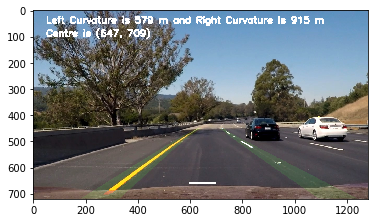

In [25]:
def process_image(image):
    
    binary_warped, M = birds_eye(image) 

    Minv = np.linalg.inv(M)
    w, h = image.shape[1], image.shape[0]
    
    out_image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, disp_fit=False)
    
    out_image = cv2.warpPerspective(out_image, Minv, (w, h))
    
    result = cv2.addWeighted(image, 1, out_image, 0.3, 0)
    
    #out_image, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, disp_fit=False)

    if len(left_fitx) != 0 and len(left_fitx) != 0:
        
        left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty)
            
        cx, cy = get_centre(left_fitx, right_fitx, ploty)

        msg1 = f'Left Curvature is {int(left_curverad)} m and Right Curvature is {int(right_curverad)} m'

        msg2 = f'Centre is ({cx}, {cy})'

        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cv2.putText(result, msg1, (50,50), font, 1.2, (255,255,255), 5)
        cv2.putText(result, msg2, (50, 100), font, 1.2, (255,255,255), 5)
        
        wid = 50
        cv2.line(result, (cx-wid, cy-50), (cx+wid, cy-50), (255,255,255), 4 )
        
    return result

images = glob.glob('./test_images/*.jpg')
image = images[0]
image = mpimage.imread(image)
image = process_image(image)
plt.imshow(image);

In [26]:
vid_output = './data/project_video_marked.mp4'

clip = VideoFileClip('./data/project_video.mp4')

clip_marked = clip.fl_image(lambda image: process_image(image))

clip_marked.write_videofile(vid_output, audio=False)


t:   0%|          | 3/1260 [00:00<00:48, 25.75it/s, now=None]

Moviepy - Building video ./data/project_video_marked.mp4.
Moviepy - Writing video ./data/project_video_marked.mp4



Moviepy - Done !
Moviepy - video ready ./data/project_video_marked.mp4
